In [1]:
from contextlib import suppress
from http.client import HTTPConnection
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from c8y_tk.interactive import CumulocityContext

## Intializing the Cumulocity context

A (temporarily) authenticated connection to Cumulocity can be obtained best using the `CumulocityContext` class which
- uses standard `C8Y_*` environment variables when provided
- interactively queries for additional necessary information, e.g. the user's password of current TFA token

In [2]:
with CumulocityContext() as c8y:
    cu = c8y.users.get_current()
    print(f"Current user's full name: {cu.first_name} {cu.last_name}")

Current user's full name: None None


When using Jupyter, a context manager might not be practical, but the `CumulocityContext` class can be normally instantiated as well. Then the connection can be reused in subsequent cells:

In [3]:
c8y = CumulocityContext()

## Querying data

The Cumulocity Python API is not only for implementing microservices. Its user-friendly design and full code completion support makes it fun to used in interactive session as well. This works in Jupyter notebooks as well (as you might have guessed - looking at such a notebook).

In [5]:
print("Last registered devices:")
for d in c8y.device_inventory.select(query="$orderby=creationTime desc", limit=20):
    serial = d.get('c8y_Hardware.serialNumber', '-')
    print(f" - {d.name} (#{d.id}), Serial: {serial}, Registered: {d.creation_time}")

Last registered devices:
 - cb4-a1eucpg1qb2348000271 (#11108352873306), Serial: A1EUCPG1QB2348000271, Registered: 2025-02-24T10:04:29.546Z
 - cb4-a2eucpg1qa2427001604 (#75108352801463), Serial: A2EUCPG1QA2427001604, Registered: 2025-02-24T10:03:14.281Z
 - cb4-a2eucpg1qa2343000240 (#51108352773261), Serial: A2EUCPG1QA2343000240, Registered: 2025-02-24T10:02:45.770Z
 - cb4-a2eucpg1qa2437003870 (#58108352759226), Serial: A2EUCPG1QA2437003870, Registered: 2025-02-24T10:02:28.465Z
 - cb4-a2eucpg1qa2305004882 (#47108352591111), Serial: A2EUCPG1QA2305004882, Registered: 2025-02-24T09:59:34.708Z
 - cb4-a2xpccg1qa2435000782 (#66108352526687), Serial: A2XPCCG1QA2435000782, Registered: 2025-02-24T09:58:22.240Z
 - cb4-a2eucpg1qa2431000369 (#55108352432313), Serial: A2EUCPG1QA2431000369, Registered: 2025-02-24T09:56:49.513Z
 - cb4-a2eucpg1qa2427000701 (#29108352365404), Serial: A2EUCPG1QA2427000701, Registered: 2025-02-24T09:55:37.166Z
 - cb4-a2eucpg1qa2341000032 (#99108352308992), Serial: A2EUCPG1

## Working with measurements

Let's check whether there are some measurements we can work with. First we get the latest measurements and check which devices were involved:

Number of measurements per device:
492574052         2
8663784672577     2
19600551190       2
92102232595772    2
6965225274948     2
                 ..
213650100         1
1435442369        1
272924599         1
34088289          1
477686994         1
Name: count, Length: 966, dtype: int64


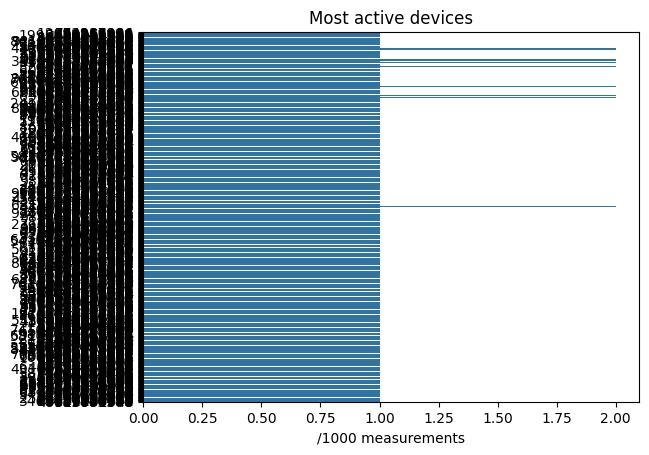

In [6]:
ms = c8y.measurements.get_all(before='now', reverse=True, limit=1000)
device_ids = [m.source for m in ms]

print("Number of measurements per device:")
print(pd.Series(device_ids).value_counts())

fig = sns.countplot(device_ids)
plt.title("Most active devices")
plt.xlabel("/1000 measurements")
plt.show()

We choose the most active device and plot the measurements of the same kind:

In [7]:
top_device = pd.Series(device_ids).value_counts().index[0]
print(f"Most active device: {top_device}")

def get_series(m):
    return [f'{k1}.{k2}' for k1, v1 in m.fragments.items() for k2 in v1.keys()]

# get defined series names for found measurements
device_ms = [m for m in ms if m.source == top_device]
device_series = [get_series(m)[0] for m in device_ms]

top_series = pd.Series(device_series).value_counts().index[0]
print(f"Most used series: {top_series}")

Most active device: 492574052
Most used series: c8y_SignalStrength.rssi


## Visualizing data

Let's put this into a diagram:

In [8]:
category, series = top_series.split('.')

# get max 100 values from this series
values = [(m.datetime, m[category][series]['value']) for i, m in enumerate(device_ms) if category in m and series in m[category] and i < 100]
values_df = pd.DataFrame(values, columns=['date', 'value'])
values_df.head()

,date,value
0,2025-02-24 10:08:12.788000+00:00,-69


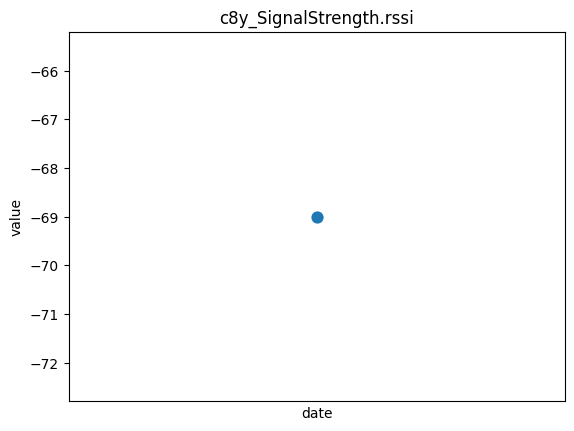

In [9]:
sns.pointplot(data=values_df, x='date', y='value')
plt.title(top_series)
plt.xticks(ticks=[], labels=[])
plt.show()